In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
import numpy as np
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import networkx as nx
from PIL import Image

c:\Users\aydhi\OneDrive\Documents\capstone\TRY2\.venv\Lib\site-packages\torch_geometric\typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
c:\Users\aydhi\OneDrive\Documents\capstone\TRY2\.venv\Lib\site-packages\torch_geometric\typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
c:\Users\aydhi\OneDrive\Documents\capstone\TRY2\.venv\Lib\site-packages\torch_geometric\typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(
c:\Users\aydhi\OneDrive\Documents\capstone\TRY2\.venv\Lib\site-pa

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

root_dir = "lung_image_sets"
feature_file = "features.pt"
label_file = "labels.pt"
checkpoint_file = "best_model.pth"

In [4]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = models.resnet152(pretrained=True)
        self.model.fc = nn.Linear(2048, 512)  # Reduce output size to 512

    def forward(self, x):
        return self.model(x)

In [5]:
feature_extractor = FeatureExtractor().to(device).eval()


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

c:\Users\aydhi\OneDrive\Documents\capstone\TRY2\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\aydhi\OneDrive\Documents\capstone\TRY2\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
dataset = datasets.ImageFolder(root_dir, transform=transform)

if os.path.exists(feature_file) and os.path.exists(label_file):
    features = torch.load(feature_file)
    labels = torch.load(label_file)
else:
    dataloader = DataLoader(dataset, batch_size=8, num_workers=4, pin_memory=True)
    features, labels = [], []

    with torch.no_grad():
        for images, label_batch in dataloader:
            images = images.to(device)
            feats = feature_extractor(images).cpu() 
            features.append(feats)
            labels.append(label_batch)

    features = torch.cat(features)
    labels = torch.cat(labels)
    torch.save(features, feature_file)
    torch.save(labels, label_file)

C:\Users\aydhi\AppData\Local\Temp\ipykernel_14032\1215869614.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  features = torch.load(feature_file)
C:\Users\aydhi\AppData\L

In [7]:
train_indices, test_indices = train_test_split(range(len(labels)), test_size=0.2, random_state=42)
train_features, test_features = features[train_indices], features[test_indices]
train_labels, test_labels = labels[train_indices], labels[test_indices]

In [8]:
class GATClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, heads=4):
        super().__init__()
        self.gat1 = GATConv(input_dim, hidden_dim, heads=heads, concat=True)
        self.gat2 = GATConv(hidden_dim * heads, hidden_dim, heads=heads, concat=True)
        self.gat3 = GATConv(hidden_dim * heads, output_dim, heads=1, concat=False)

    def forward(self, data):
        x, edge_index = data.x.to(device), data.edge_index.to(device)
        x = F.elu(self.gat1(x, edge_index))
        x = F.elu(self.gat2(x, edge_index))
        x = self.gat3(x, edge_index)
        return x

In [9]:
class GATClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, heads=4):
        super().__init__()
        self.gat1 = GATConv(input_dim, hidden_dim, heads=heads, concat=True)
        self.gat2 = GATConv(hidden_dim * heads, hidden_dim, heads=heads, concat=True)
        self.gat3 = GATConv(hidden_dim * heads, output_dim, heads=1, concat=False)

    def forward(self, data):
        x, edge_index = data.x.to(device), data.edge_index.to(device)
        x = F.elu(self.gat1(x, edge_index))
        x = F.elu(self.gat2(x, edge_index))
        x = self.gat3(x, edge_index)
        return x

In [10]:
def create_knn_graph(features, k=5):
    from sklearn.neighbors import kneighbors_graph
    adjacency = kneighbors_graph(features.cpu().numpy(), k, mode='connectivity', include_self=False)
    edge_index = np.array(adjacency.nonzero())
    return torch.tensor(edge_index, dtype=torch.long)

edge_index = create_knn_graph(train_features, k=5)
train_data = Data(x=train_features.to(device), y=train_labels.to(device), edge_index=edge_index.to(device))

test_edge_index = create_knn_graph(test_features, k=5)
test_data = Data(x=test_features.to(device), y=test_labels.to(device), edge_index=test_edge_index.to(device))

model = GATClassifier(input_dim=512, hidden_dim=64, output_dim=len(torch.unique(train_labels))).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

In [11]:
# def train():
#     model.train()
#     optimizer.zero_grad()
#     out = model(train_data)
#     loss = criterion(out, train_data.y)
#     loss.backward()
#     optimizer.step()
#     return loss.item()


# def test(data):
#     model.eval()
#     with torch.no_grad():
#         logits = model(data)
#         pred = logits.argmax(dim=1)
#         acc = (pred == data.y).sum().item() / data.y.size(0)
#         return acc, pred


# for epoch in range(600):
#     loss = train()
#     acc, _ = test(test_data)
#     print(f"Epoch {epoch+1}: Loss = {loss:.4f}, Test Acc = {acc:.4f}")


# torch.save(model.state_dict(), checkpoint_file)

In [12]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(train_data)
    loss = criterion(out, train_data.y)
    loss.backward()
    optimizer.step()
    return loss.item()


def test(data):
    model.eval()
    with torch.no_grad():
        logits = model(data)
        pred = logits.argmax(dim=1)
        acc = (pred == data.y).sum().item() / data.y.size(0)
        return acc, pred
    
for epoch in range(600):
    loss = train()
    acc, _ = test(test_data)
    print(f"Epoch {epoch+1}: Loss = {loss:.4f}, Test Acc = {acc:.4f}")

torch.save(model.state_dict(), checkpoint_file)

Epoch 1: Loss = 1.1410, Test Acc = 0.3345
Epoch 2: Loss = 8.4255, Test Acc = 0.5125
Epoch 3: Loss = 12.7065, Test Acc = 0.3381
Epoch 4: Loss = 22.8412, Test Acc = 0.3381
Epoch 5: Loss = 10.1803, Test Acc = 0.6269
Epoch 6: Loss = 1.4149, Test Acc = 0.4039
Epoch 7: Loss = 1.1011, Test Acc = 0.3488
Epoch 8: Loss = 2.2157, Test Acc = 0.5261
Epoch 9: Loss = 1.2895, Test Acc = 0.7999
Epoch 10: Loss = 0.3535, Test Acc = 0.6583
Epoch 11: Loss = 0.6704, Test Acc = 0.7470
Epoch 12: Loss = 0.4765, Test Acc = 0.9064
Epoch 13: Loss = 0.2365, Test Acc = 0.8585
Epoch 14: Loss = 0.3703, Test Acc = 0.8878
Epoch 15: Loss = 0.2961, Test Acc = 0.9192
Epoch 16: Loss = 0.2378, Test Acc = 0.8956
Epoch 17: Loss = 0.3083, Test Acc = 0.8906
Epoch 18: Loss = 0.3282, Test Acc = 0.9049
Epoch 19: Loss = 0.2543, Test Acc = 0.9192
Epoch 20: Loss = 0.2088, Test Acc = 0.9178
Epoch 21: Loss = 0.2133, Test Acc = 0.9142
Epoch 22: Loss = 0.2303, Test Acc = 0.9142
Epoch 23: Loss = 0.2170, Test Acc = 0.9185
Epoch 24: Loss = 

In [13]:
def visualize_features(features, image_idx):
    """Visualize extracted features."""
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(features[image_idx].cpu().numpy(), marker='o')
    ax.set_title(f'Feature Embeddings for Image {image_idx}')
    ax.set_xlabel('Feature Index')
    ax.set_ylabel('Feature Value')
    return fig 



def visualize_attention_weights(attn_weights, edge_index, image_idx):
    G = nx.Graph()
    edges = edge_index.cpu().numpy().T
    for i, (src, tgt) in enumerate(edges):
        G.add_edge(src, tgt, weight=attn_weights[i].cpu().numpy())
    
    fig, ax = plt.subplots(figsize=(8, 8))
    pos = nx.spring_layout(G)
    weights = [G[u][v]['weight'] for u, v in G.edges()]
    
    nx.draw(G, pos, edges=G.edges(), width=weights, node_color='lightblue', with_labels=True, ax=ax)
    ax.set_title(f'Attention Graph for Image {image_idx}')
    return fig 




PDF Report for batch 1 saved as classification_report_batch_1.pdf
PDF Report for batch 2 saved as classification_report_batch_2.pdf
PDF Report for batch 3 saved as classification_report_batch_3.pdf
PDF Report for batch 4 saved as classification_report_batch_4.pdf
PDF Report for batch 5 saved as classification_report_batch_5.pdf
PDF Report for batch 6 saved as classification_report_batch_6.pdf
PDF Report for batch 7 saved as classification_report_batch_7.pdf
PDF Report for batch 8 saved as classification_report_batch_8.pdf
PDF Report for batch 9 saved as classification_report_batch_9.pdf
PDF Report for batch 10 saved as classification_report_batch_10.pdf


KeyboardInterrupt: 

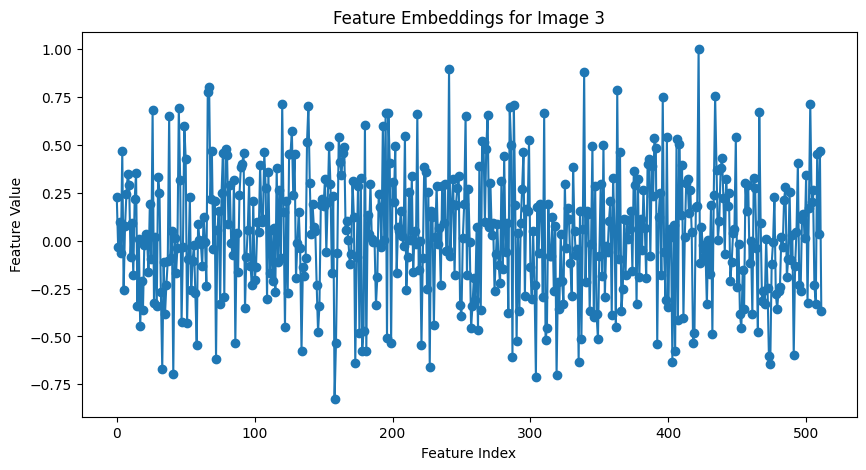

In [14]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

def generate_pdf_report_in_batches(model, test_data, dataset, test_indices, batch_size=16):
    label_mapping = {0: "Adenomous", 1: "Normal", 2: "Squamous"}
    
    num_batches = len(test_indices) // batch_size + (1 if len(test_indices) % batch_size != 0 else 0)
    
    for batch_num in range(num_batches):
        start_idx = batch_num * batch_size
        end_idx = min(start_idx + batch_size, len(test_indices))
        batch_indices = test_indices[start_idx:end_idx]
        
        output_pdf = f"classification_report_batch_{batch_num + 1}.pdf"
        
        with PdfPages(output_pdf) as pdf:
            acc, pred = test(test_data)

            for i, idx in enumerate(batch_indices):
                image_path, true_label = dataset.samples[idx]
                image = plt.imread(image_path)
                
                true_label_str = label_mapping.get(true_label, "Unknown")
                pred_label_str = label_mapping.get(pred[i].item(), "Unknown")
                
                fig, axs = plt.subplots(1, 1, figsize=(12, 6))
                axs.imshow(image)
                axs.axis('off')
                axs.set_title(f'Test Image {i+1}\nTrue Label: {true_label_str}\nPredicted: {pred_label_str}')

                pdf.savefig(fig) 
                plt.close(fig)

                feature_fig = visualize_features(test_data.x, i)
                pdf.savefig(feature_fig)
                plt.close(feature_fig)

        print(f'PDF Report for batch {batch_num + 1} saved as {output_pdf}')

generate_pdf_report_in_batches(model, test_data, dataset, test_indices)

Epoch 1: Loss = 0.0869, Test Acc = 0.9271
Epoch 2: Loss = 0.0810, Test Acc = 0.9328
Epoch 3: Loss = 0.0769, Test Acc = 0.9328
Epoch 4: Loss = 0.0792, Test Acc = 0.9314
Epoch 5: Loss = 0.0775, Test Acc = 0.9314
Epoch 6: Loss = 0.0728, Test Acc = 0.9342
Epoch 7: Loss = 0.0732, Test Acc = 0.9342
Epoch 8: Loss = 0.0729, Test Acc = 0.9357
Epoch 9: Loss = 0.0687, Test Acc = 0.9314
Epoch 10: Loss = 0.0678, Test Acc = 0.9321
Epoch 11: Loss = 0.0682, Test Acc = 0.9321
Epoch 12: Loss = 0.0655, Test Acc = 0.9328
Epoch 13: Loss = 0.0645, Test Acc = 0.9299
Epoch 14: Loss = 0.0651, Test Acc = 0.9321
Epoch 15: Loss = 0.0631, Test Acc = 0.9342
Epoch 16: Loss = 0.0618, Test Acc = 0.9328
Epoch 17: Loss = 0.0619, Test Acc = 0.9321
Epoch 18: Loss = 0.0604, Test Acc = 0.9328
Epoch 19: Loss = 0.0588, Test Acc = 0.9299
Epoch 20: Loss = 0.0587, Test Acc = 0.9321
Epoch 21: Loss = 0.0577, Test Acc = 0.9314
Epoch 22: Loss = 0.0563, Test Acc = 0.9307
Epoch 23: Loss = 0.0563, Test Acc = 0.9321
Epoch 24: Loss = 0.0

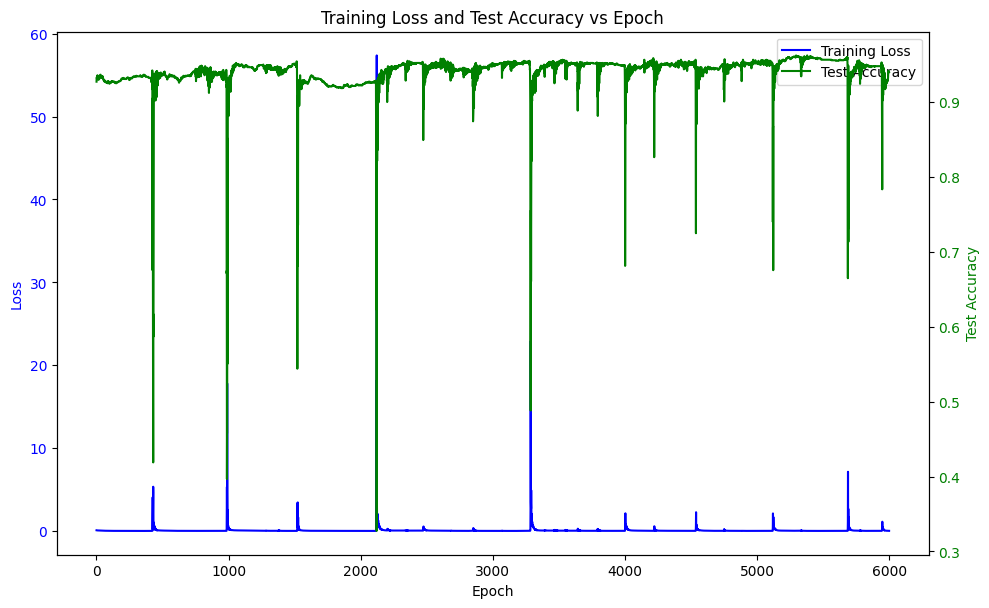

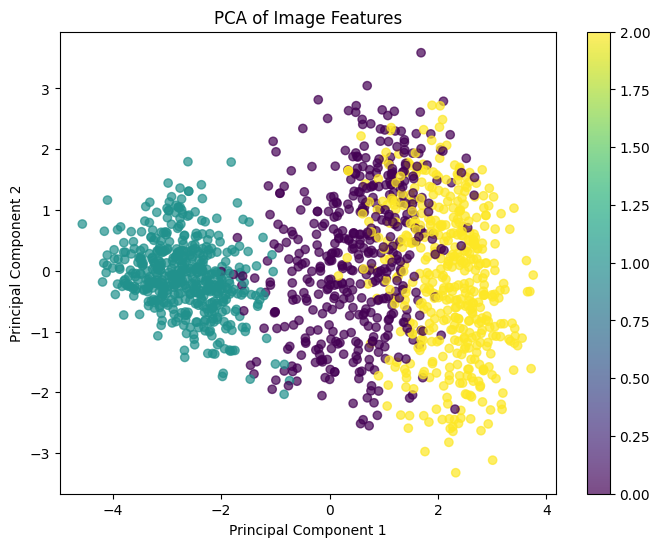

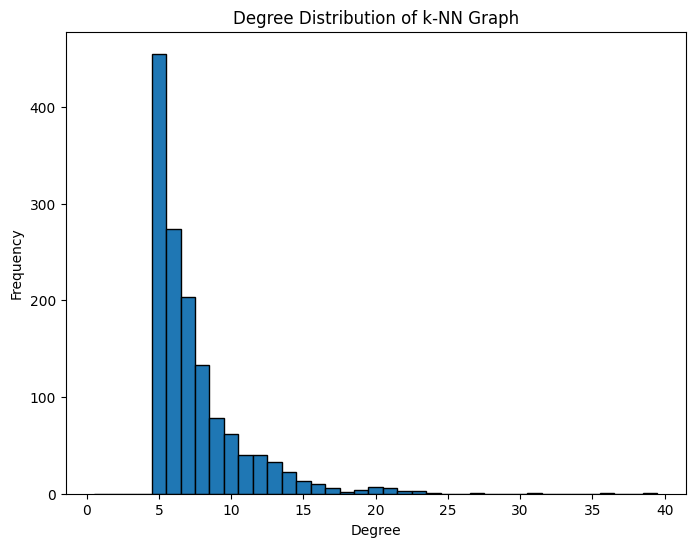

In [ ]:
train_losses = []
test_accuracies = []
num_epochs = 6000

for epoch in range(num_epochs):
    loss = train()
    acc, _ = test(test_data)
    train_losses.append(loss)
    test_accuracies.append(acc)
    print(f"Epoch {epoch+1}: Loss = {loss:.4f}, Test Acc = {acc:.4f}")


fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(range(1, num_epochs+1), train_losses, label="Training Loss", color="blue")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

ax2 = ax1.twinx()
ax2.plot(range(1, num_epochs+1), test_accuracies, label="Test Accuracy", color="green")
ax2.set_ylabel("Test Accuracy", color="green")
ax2.tick_params(axis="y", labelcolor="green")

fig.tight_layout()
plt.title("Training Loss and Test Accuracy vs Epoch")

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="upper right")
plt.show()


from sklearn.decomposition import PCA

def visualize_pca(features, labels):
    """
    Visualize a 2D PCA projection of the features.
    """
    pca = PCA(n_components=2)
    features_2d = pca.fit_transform(features.cpu().numpy())
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels.cpu().numpy(), cmap="viridis", alpha=0.7)
    plt.colorbar(scatter)
    plt.title("PCA of Image Features")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.show()


visualize_pca(test_features, test_labels)

def visualize_knn_degree_distribution(edge_index, num_nodes):
    """
    Visualize the degree distribution of the k-NN graph.
    """
    G = nx.Graph()
    
    for i in range(num_nodes):
        G.add_node(i)
    
    for src, tgt in edge_index.t().cpu().numpy():
        G.add_edge(src, tgt)
    
        degrees = [d for n, d in G.degree()]
    
    plt.figure(figsize=(8, 6))
    plt.hist(degrees, bins=range(1, max(degrees)+2), edgecolor="black", align="left")
    plt.title("Degree Distribution of k-NN Graph")
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.show()

visualize_knn_degree_distribution(test_data.edge_index, test_features.shape[0])

In [ ]:
model = GATClassifier(input_dim=512, hidden_dim=64, output_dim=len(torch.unique(train_labels))).to(device)
model.load_state_dict(torch.load(checkpoint_file))
model.eval()

def classify_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        feature = feature_extractor(image).cpu()
    
    logits = model(Data(x=feature.to(device), edge_index=edge_index.to(device)))
    pred_label = logits.argmax().item()
    
    class_name = dataset.classes[pred_label]
    print(f'Predicted class: {class_name}')
    return class_name

C:\Users\aydhi\AppData\Local\Temp\ipykernel_7316\2286049918.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_file))


In [ ]:
def generate_pdf_report_in_batches(model, test_data, dataset, test_indices, batch_size=16):

    
    model.eval()
    num_batches = (len(test_indices) + batch_size - 1) // batch_size 
    
    for batch_num in range(num_batches):
        start_idx = batch_num * batch_size
        end_idx = min(start_idx + batch_size, len(test_indices))
        batch_indices = test_indices[start_idx:end_idx]
        
        output_pdf = f"classification_report_batch_{batch_num + 1}.pdf"
        
        with PdfPages(output_pdf) as pdf:
            acc, pred = test(test_data)
            
            for i, idx in enumerate(batch_indices):
                image_path, true_label = dataset.samples[idx]
                image = plt.imread(image_path)
                

                fig, axs = plt.subplots(1, 2, figsize=(12, 6))
                axs[0].imshow(image)
                axs[0].axis('off')
                axs[0].set_title(f'Test Image {i+1}\nTrue Label: {true_label}\nPredicted: {pred[idx].item()}')

                pdf.savefig(fig)  
                plt.close(fig)

                feature_fig = visualize_features(test_data.x, idx)
                pdf.savefig(feature_fig)
                plt.close(feature_fig)

        print(f'PDF Report for batch {batch_num + 1} saved as {output_pdf}')


generate_pdf_report_in_batches(model, test_data, dataset, test_indices, batch_size=16)


RuntimeError: CUDA error: CUBLAS_STATUS_EXECUTION_FAILED when calling `cublasSgemm( handle, opa, opb, m, n, k, &alpha, a, lda, b, ldb, &beta, c, ldc)`